# Let's Evaluate Tiny MoE





### Configure the machine and install packages


In [1]:
from typing import Literal

import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../alpha-448101-282bc1b884cd.json"
#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax

platform : Literal["darwin", "colab", "cuda", "tpu"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"
    if any(d.platform == "tpu" for d in devices):
        platform = "tpu"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on cuda


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/root/jaxpt/src


In [3]:
import os


import warnings

import jax
from jax.sharding import Mesh, PartitionSpec, NamedSharding
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)

devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

#jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Set up device mesh


mesh = jax.sharding.Mesh(jax.devices(), ["devices"])

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.7.0
Flax version 0.11.1
Available devices: 8
using gpu
1.35 ms ± 9.99 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
from flax import nnx

from jaxpt.models import Tiny_MoE_Config, Tiny_MoE
from jaxpt.utils import count_params, create_sharded_model
from jaxpt.checkpointers import load_checkpoint_from_gcloud

import tiktoken
from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = Tiny_MoE_Config(dtype=jnp.bfloat16, \
                     vocab_size=49152,
                     n_layer=30,
                     block_size=2048,
                     n_head=9,
                     n_kv_head=3,
                     n_mlp_hidden=1536,
                     moe_bias=False,
                     mlp_bias=False,
                     attention_bias=False,
                     z_loss_coeff=1e-4,
                     expert_weight_priority=False,
                     load_factor=10.0,
                     ln_epsilon=1e-5,
                     use_cache=False,
                     sdpa_implementation="slow" #"cudnn" if device=="gpu" else "xla"
)
nnx.display(config)
with mesh:
    m = load_checkpoint_from_gcloud(Tiny_MoE, config, Path().absolute().parent , "alpha_training_runs", "run_20250826_isander_dingo", 50000, rngs)
    #m = create_sharded_model(Tiny_MoE, config, rngs)
    #m = load_checkpoint(Tiny_MoE, output_dir, config, "run_20250716_htlpzj", 180000, rngs)
    #m = load_checkpoint(Tiny_MoE, output_dir, config, "run_20250716_htlpzj", 381469, rngs)
    #m = from_hf_pretrained(config, rngs)

    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    total_params = count_params(m)
    moe_params = count_params(m, "experts")
    print(f"Parameter Count: {total_params:,}")
    print(f"MOE (Sharded) Parameter Count: {moe_params:,}")
    replicated_params = total_params - moe_params
    print(f"Replicated Parameter Count: {replicated_params:,}")
    active_params = replicated_params + ( 2 / 8 ) * moe_params
    print(f"Active Parameter Count: {active_params:,}")
    fraction_of_active_params = active_params / total_params
    print(f"% Active Parameters: {fraction_of_active_params*100:0.2f} %")

    nnx.display(state)

Parameter Count: 413,275,968
MOE (Sharded) Parameter Count: 318,504,960
Replicated Parameter Count: 94,771,008
Active Parameter Count: 174,397,248.0
% Active Parameters: 42.20 %


In [12]:
from functools import partial
from transformers import AutoTokenizer
from jaxpt.infer import generate_completion_slow
import jax


with mesh:
    enc = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-360M")
    completions = generate_completion_slow(m, enc=enc, num_completions=8,
                                    max_length=21,
                                    key=jax.random.key(9),
                                    temperature=0.5,
                                    prefix="An excellent way to spend an evening in New York City")
    for completion in completions:
        print(completion)
        print('---------------------------')

An excellent way to spend an evening in New York City, or just to get a glimpse into a new
---------------------------
An excellent way to spend an evening in New York City is to travel to the many Broadway theaters. While
---------------------------
An excellent way to spend an evening in New York City is to take a boat ride. You can rent
---------------------------
An excellent way to spend an evening in New York City is to visit the Statue of Liberty. The Statue
---------------------------
An excellent way to spend an evening in New York City is to visit the Statue of Liberty. The Statue
---------------------------
An excellent way to spend an evening in New York City is to visit the Statue of Liberty. The Statue
---------------------------
An excellent way to spend an evening in New York City is to spend the day there. It is a
---------------------------
An excellent way to spend an evening in New York City is to visit the Statue of Liberty. The Statue
---------------------------


## Train Curve

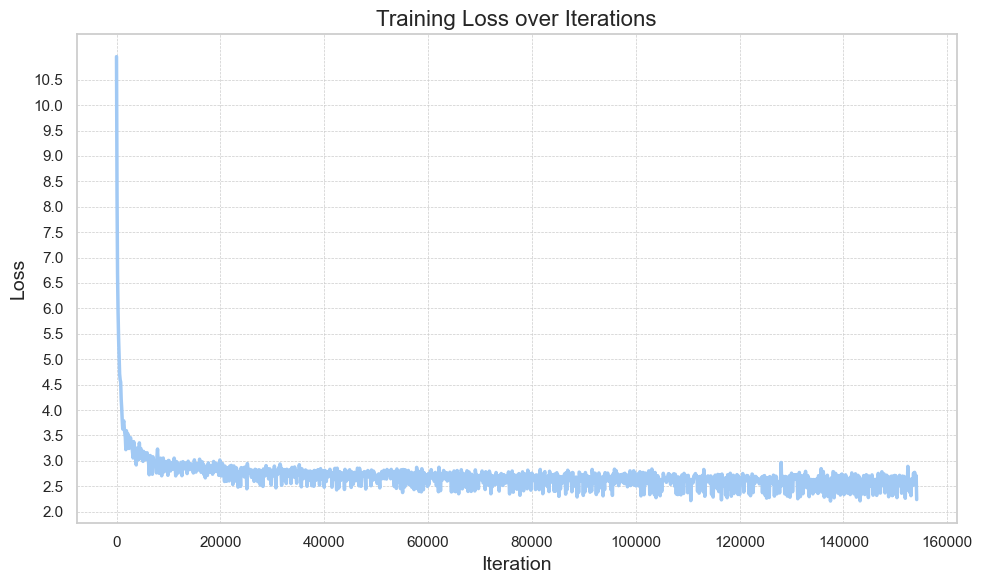

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

df = pd.read_csv("../logs/Tiny_MoE_logs_run_20250722_uhixrg_train (1).csv")

# Extract iterations and loss columns (replace with actual column names if different)
iterations = df['step']
loss = df['loss']

# Set pastel style
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(10, 6))
sns.lineplot(x=iterations, y=loss, linewidth=2.5)
plt.title('Training Loss over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.yticks(np.arange(int(loss.min()), int(loss.max()) + 1, 0.5))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()